<a href="https://colab.research.google.com/github/Anastasiia-Khab/homeworks-ucu/blob/master/task6_PatchMatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### task6

##### by Anastasiia Khaburska

## Patch Match algorithm


Wikipedia page : https://en.wikipedia.org/wiki/PatchMatch

The article: https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/

In [0]:
import numpy as np
from PIL import Image
import time
import cv2
import matplotlib.pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow

%matplotlib inline

1. Initialize pixels with random patch
offsets (a)
2. Check if neighbors have better patch
offsets (b) The order of propagation changes one by one.
3. Search in concentric radius around
the current offset for better
patch offsets (c)
4. Go to Step 2 until converge.

In [0]:
#Patch match algorithm
#img1
#img2
#patch_size
#iterations 
#alpha for desiding the size of the rectangle of random search
#power for desiding the number of the concentrative rectangles of random search
def PatchMatch(img1, img2, patch_size, iterations, alpha, power):
    A_h = np.size(img1, 0)
    A_w = np.size(img1, 1)
    matching, matching_delta, img_padding = initialization(img1, img2, patch_size)
    for iteration in range(1, iterations+1):
        if iteration % 2 == 0:
            for a_x in range(A_h - 1, -1, -1):
                for a_y in range(A_w - 1, -1, -1):
                    propagation(matching, a_x , a_y , matching_delta, img_padding, img2, patch_size, False)
                    random_search(matching, a_x, a_y, matching_delta, img_padding, img2, patch_size, alpha, power)
        else:
            for a_x in range(A_h):
                for a_y in range(A_w):
                    propagation(matching, a_x, a_y, matching_delta, img_padding, img2, patch_size, True)
                    random_search(matching, a_x, a_y, matching_delta, img_padding, img2, patch_size, alpha, power)
        print("iteration: %d"%(iteration))
    return matching, matching_delta

#Initialization
#a_padding - matrix a with paddings
#first matchig is choosen randomly
#delta for all the points in A
def initialization(A, B, patch_size):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = patch_size // 2
    #рендомно значення у матриці В центрів патчів. відповідно від будь які крім крайніх. Для кожного пікселя з А
    random_B_r = np.random.randint(p, B_h-p, [A_h, A_w])
    random_B_c = np.random.randint(p, B_w-p, [A_h, A_w])
    A_padding = np.ones([A_h+p*2, A_w+p*2, 3]) * np.nan
    A_padding[p:A_h+p, p:A_w+p, :] = A
    matching = np.zeros([A_h, A_w], dtype=object)
    matching_delta = np.zeros([A_h, A_w])
    for a_x in range(A_h):
        for a_y in range(A_w):
            b = np.array([random_B_r[a_x, a_y], random_B_c[a_x, a_y]], dtype=np.int32)
            matching[a_x, a_y] = b
            matching_delta[a_x, a_y] = point_delta(a_x, a_y, b, A_padding, B, patch_size)
    return matching, matching_delta, A_padding

#finds out the relative delta between the two patches maped  by the matching. relative because several pixels may be Nans.
#matching_delta = sum(|delta(a_patch,b_patch)|)
def point_delta(a_x, a_y, b, A_padding, B, patch_size):
    b_x = b[0]
    b_y = b[1]
    p = patch_size // 2
    a_patch = A_padding[a_x:a_x+patch_size, a_y:a_y+patch_size, :]
    b_patch = B[b[0]-p:b[0]+p+1, b[1]-p:b[1]+p+1, :]
    temp = a_patch - b_patch
    num = np.sum(1 - np.int32(np.isnan(temp)))
    p_delta = np.sum(np.abs(np.nan_to_num(temp))) / num
    return p_delta


#propagation - finding better patches in the neighborhood for all the points in A
#if iteration is odd then we move from the right bottom to the left top.
#if iteration is even then we move from the left top to the right bottom.
def propagation(matching, a_x, a_y, matching_delta, A_padding, B, patch_size, iteration_is_odd):
    A_h = np.size(A_padding, 0) - patch_size + 1
    A_w = np.size(A_padding, 1) - patch_size + 1
    if iteration_is_odd:
        d_left = matching_delta[max(a_x-1, 0), a_y]
        d_up = matching_delta[a_x, max(a_y-1, 0)]
        d_current = matching_delta[a_x, a_y]
        idx = np.argmin(np.array([d_current, d_left, d_up]))
        if idx == 1:
            matching[a_x, a_y] = matching[max(a_x - 1, 0), a_y]
            matching_delta[a_x, a_y] = point_delta(a_x, a_y, matching[a_x, a_y], A_padding, B, patch_size)
        if idx == 2:
            matching[a_x, a_y] = matching[a_x, max(a_y - 1, 0)]
            matching_delta[a_x, a_y] = point_delta(a_x, a_y, matching[a_x, a_y], A_padding, B, patch_size)
    else:
        d_right = matching_delta[min(a_x + 1, A_h-1), a_y]
        d_down = matching_delta[a_x, min(a_y + 1, A_w-1)]
        d_current = matching_delta[a_x, a_y]
        idx = np.argmin(np.array([d_current, d_right, d_down]))
        if idx == 1:
            matching[a_x, a_y] = matching[min(a_x + 1, A_h-1), a_y]
            matching_delta[a_x, a_y] = point_delta(a_x, a_y, matching[a_x, a_y], A_padding, B, patch_size)
        if idx == 2:
            matching[a_x, a_y] = matching[a_x, min(a_y + 1, A_w-1)]
            matching_delta[a_x, a_y] = point_delta(a_x, a_y, matching[a_x, a_y], A_padding, B, patch_size)

#finds random matchings in concentrated rectangles around the previous matchig (selected during the propagation step)
#selects the best matchig out of this random and previous one
def random_search(matching, a_x, a_y , matching_delta, A_padding, B, patch_size, alpha, power):
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = patch_size // 2
    i = power
    search_h = B_h * alpha ** i
    search_w = B_w * alpha ** i
    b_x = matching[a_x, a_y][0]
    b_y = matching[a_x, a_y][1]
    while search_h > 1 and search_w > 1:
        search_min_r = max(b_x - search_h, p)
        search_max_r = min(b_x + search_h, B_h-p)
        random_b_x = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(b_y - search_w, p)
        search_max_c = min(b_y + search_w, B_w - p)
        random_b_y = np.random.randint(search_min_c, search_max_c)
        search_h = B_h * alpha ** i
        search_w = B_w * alpha ** i
        random_b_match_point = np.array([random_b_x, random_b_y])
        delta = point_delta(a_x, a_y, random_b_match_point, A_padding, B, patch_size)
        if delta < matching_delta[a_x, a_y]:
            matching_delta[a_x, a_y] = delta
            matching[a_x, a_y] = random_b_match_point
        i += 1
        


Reading of to images of the helicopter made with some delay while the helicopter was flying

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v001.jpg
downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v010.jpg
180
320


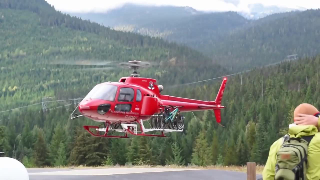

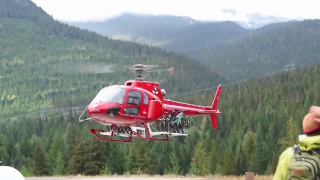

In [0]:
#img1 = np.array(Image.open("./v001.jpg"))
#img2 = np.array(Image.open("./v010.jpg"))

def url_to_image(url):
  print("downloading %s" % (url))
  return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

url1 = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v001.jpg"
url2 = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v010.jpg"
img1 = cv2.resize(url_to_image(url1), (0,0), fx=0.25, fy=0.25)
img2 = cv2.resize(url_to_image(url2), (0,0), fx=0.25, fy=0.25)

print(np.size(img1, 0))
print(np.size(img2, 1))

cv2_imshow(img1)
cv2_imshow(img2)

Parameters for the simple and quick patchmatch but not precise.

In [0]:
patch_size = 5
iterations = 2
alpha = 0.2
power = 6
start = time.time()
matching, matching_delta = PatchMatch(img1, img2, patch_size, iterations, alpha, power)
end = time.time()
print(end - start)

iteration: 1
iteration: 2
11.213255167007446


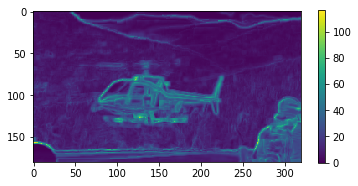

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1)
im = axes.imshow(matching_delta)

fig.colorbar(im, ax=axes, shrink=0.7)

plt.show()

By changing the paraeters the Patch Match algorithm may compute match longer but with a better precision.

In [0]:
patch_size = 3
iterations = 6
alpha = 0.5
power = 4
start = time.time()
matching, matching_delta = PatchMatch(img1, img2, patch_size, iterations, alpha, power)
end = time.time()
print(end - start)

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
139.92630696296692


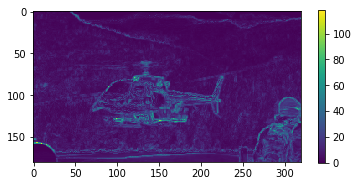

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1)
im = axes.imshow(matching_delta)

fig.colorbar(im, ax=axes, shrink=0.7)

plt.show()

The Patch Match algorithm may also be used to resturct the images. 
For example, given the matching matrix we can restruct the A image out of given image B and vise versa.

In [0]:
def reconstruction(matching, A, B):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    temp = np.zeros_like(A)
    for a_x in range(A_h):
        for a_y in range(A_w):
            temp[a_x, a_y, :] = B[matching[a_x, a_y][0], matching[a_x, a_y][1], :]
    return Image.fromarray(temp)

<class 'PIL.Image.Image'>


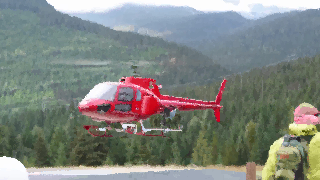

In [0]:
im=reconstruction(matching, img1, img2)
print(type(im))
cv2_imshow(np.array(im))